# Codewalk Begins

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

## Data Loading and Cleaning

In [45]:
# Loading the dataset and displaying the first 5 rows
df = pd.read_csv('heart_2020_cleaned.csv')
display(df.head())

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
df.shape

(319795, 18)

In [46]:
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00


In [5]:
## Determining the columns having NaN values by calculating % rows having null values
nan_percentage_dict = dict()
print('NaN percentage for each column : ')
name = []
percentage = []
for i in df.columns:
    name.append(i)
    s = (str((df[i].isnull().sum()/df.shape[0]*100).round(2))+'%')
    percentage.append(s)
nan_percentage_dict['name'] = name
nan_percentage_dict['percentage'] = percentage
nan_percentage_df = pd.DataFrame(nan_percentage_dict)
display(nan_percentage_df)

NaN percentage for each column : 


,name,percentage
0,HeartDisease,0.0%
1,BMI,0.0%
2,Smoking,0.0%
3,AlcoholDrinking,0.0%
4,Stroke,0.0%
5,PhysicalHealth,0.0%
6,MentalHealth,0.0%
7,DiffWalking,0.0%
8,Sex,0.0%
9,AgeCategory,0.0%


In [6]:
df['AgeCategory'].value_counts() ## The value "80 or older" needs to be changed for consistency

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

In [7]:
## Assigning "80 or older" as the value ">80" for each row
df.loc[df.AgeCategory == '80 or older', 'AgeCategory'] = '>80'

# Get unique values of agecategory and sort it to define ranking of the values
order = pd.unique(df.AgeCategory.values)
order.sort()

In [8]:
# Converting BMI into a categorical value

# Defining the intervals for BMI and assigining them names.
bins = [0, 18.5, 25, 30, 35, np.inf]
names = ['Underweight (BMI < 18.5)', 'Normal weight (18.5 <= BMI < 25.0)', 
         'Overweight (25.0 <= BMI < 30.0)', 'Obese (30.0 <= BMI < 35.0)', 'Extremly Obese (BMI >= 35.0)']

## Assigning each row a BMI category based on the interval it falls in
df['Bmi_Category'] = pd.cut(df['BMI'], bins, labels=names)

## Exploratory Data Analysis

In [9]:
# Seperating numerical and categorical columns to ensure better visualisations
numerical_cols = []
cat_cols = []
cols = df.columns
for i in range(len(cols)):
    if df[cols[i]].dtype == np.int64 or df[cols[i]].dtype == np.int32 or df[cols[i]].dtype == np.float64 or df[cols[i]].dtype == np.float32 :
        numerical_cols.append(cols[i])
    else :
        cat_cols.append(cols[i])

In [10]:
# Checking skewed features i.e. features having unbalalnced distribution of values
name = []
skew_value_list = []
skew_type_list = list()
skew_dict = dict()
for i in numerical_cols :
    name.append(i)
    skew_value = skew(df[i])
    skew_value  = float("{:.3f}".format(skew_value))
    skew_value_list.append(skew_value)
    skew_type = ''
    if(skew_value == 0.0):
        skew_type  = 'no_skew'
    elif(skew_value > 0.0):
        skew_type = 'positive'
    else :
        skew_type = 'negative'
    skew_type_list.append(skew_type)

skew_dict['col_name'] = name
skew_dict['skew_value'] = skew_value_list
skew_dict['skew_type'] = skew_type_list
skew_df = pd.DataFrame(skew_dict)
display(skew_df)

,col_name,skew_value,skew_type
0,BMI,1.332,positive
1,PhysicalHealth,2.604,positive
2,MentalHealth,2.331,positive
3,SleepTime,0.679,positive


In [11]:
# Function to plot the distribution of the skewed features
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['PhysicalHealth','MentalHealth']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

/var/folders/rf/hzyzmvcx2qj_c08ny8zf00sm0000gn/T/ipykernel_7063/3724059636.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


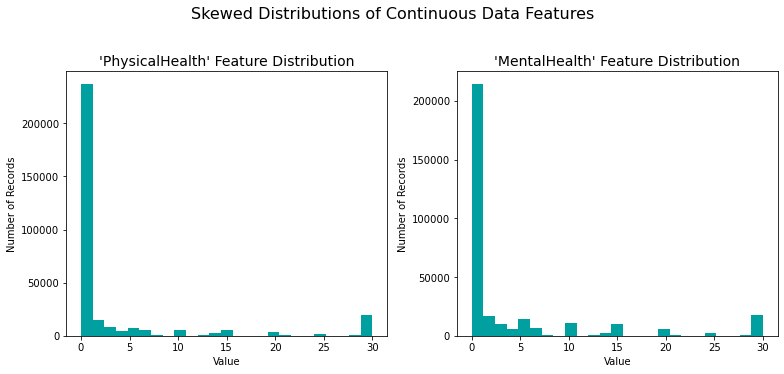

In [12]:
# Visualizing distribution of skewed data
distribution(df)

In [13]:
# transforming skewed data using the logarithmic fucntion to balance the distribution
df['PhysicalHealth'] = df['PhysicalHealth'].apply(lambda x: np.log(x + 1))
df['MentalHealth'] = df['MentalHealth'].apply(lambda x: np.log(x + 1))

/var/folders/rf/hzyzmvcx2qj_c08ny8zf00sm0000gn/T/ipykernel_7063/3724059636.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


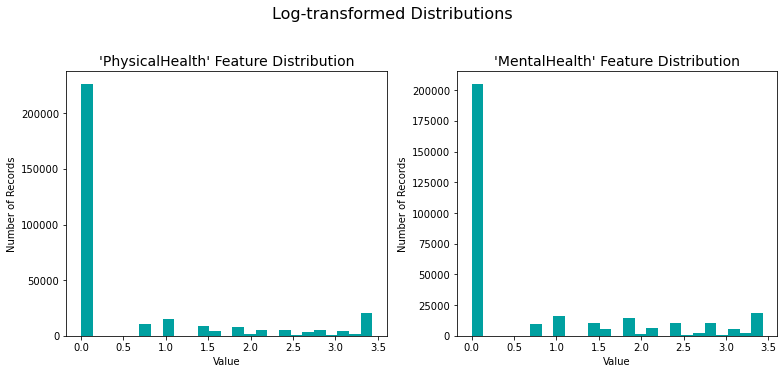

In [14]:
## Distribution after transformation of these two columns
distribution(df,transformed = True)

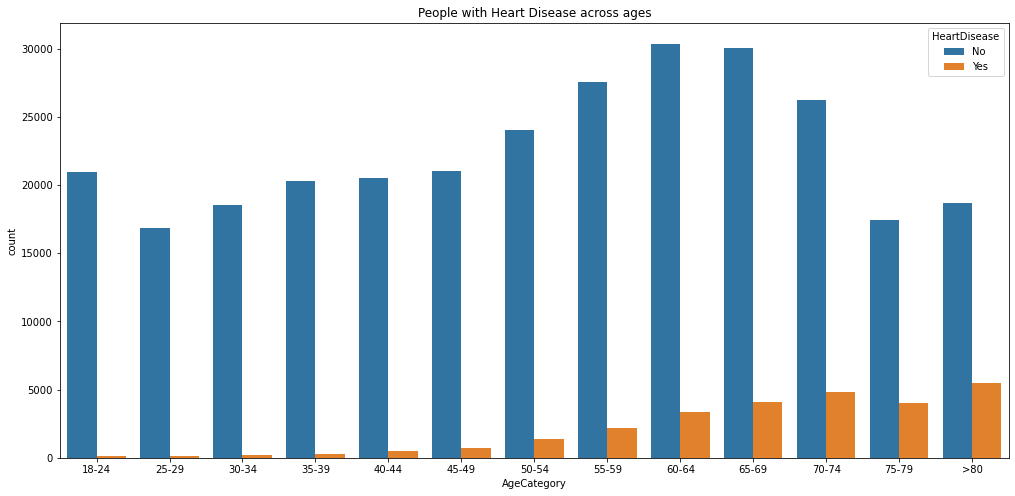

In [15]:
def plot_countplot(df,xlabel,ylabel,title,order = None):
    plt.figure(figsize=(17, 8))
    sns.countplot(data=df, x=xlabel, hue=ylabel, order=order)
    # Set the title of the plot
    plt.title(title)
    # Set the x-axis label
    plt.xlabel(xlabel)
    plt.show()

plot_countplot(df,'AgeCategory','HeartDisease','People with Heart Disease across ages',order)


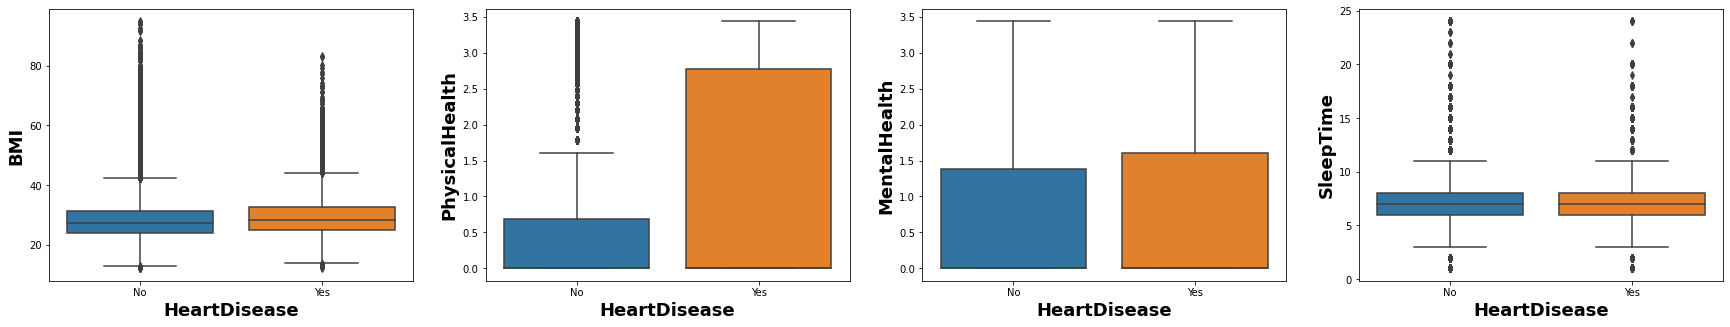

In [16]:
## Variation of Heart Disease with numerical cols:
plt.figure(figsize=(30, 5))
plt.tight_layout(pad=5)
index = 1
for i in numerical_cols:
    ax = plt.subplot(1, 4, index)
    sns.boxplot(x="HeartDisease", y= i , data=df)
    ax.set_xlabel("HeartDisease", fontsize=18, fontweight='bold')
    ax.set_ylabel(i, fontsize=18, fontweight='bold')
    index+=1

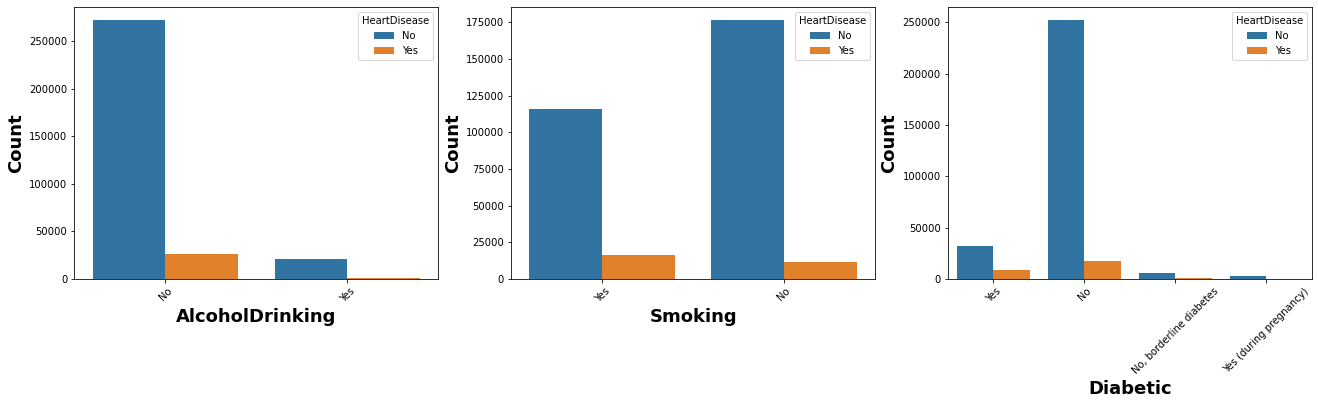

In [17]:
## Variation of Heart Disease with major lifestyle factors like consumption of Alcohol, Smoking and 
# if the person is Diabetic
plt.figure(figsize=(30, 5))
plt.tight_layout(pad=5)
index = 1
feature_cols = ['AlcoholDrinking','Smoking','Diabetic']
for i in feature_cols:
    ax = plt.subplot(1, 4, index)
    ## Formatting the plots
    sns.countplot(x=i, hue='HeartDisease' , data=df)
    ax.set_xlabel(i, fontsize=18, fontweight='bold')
    plt.xticks(rotation=45)
    ax.set_ylabel("Count", fontsize=18, fontweight='bold')
    index+=1

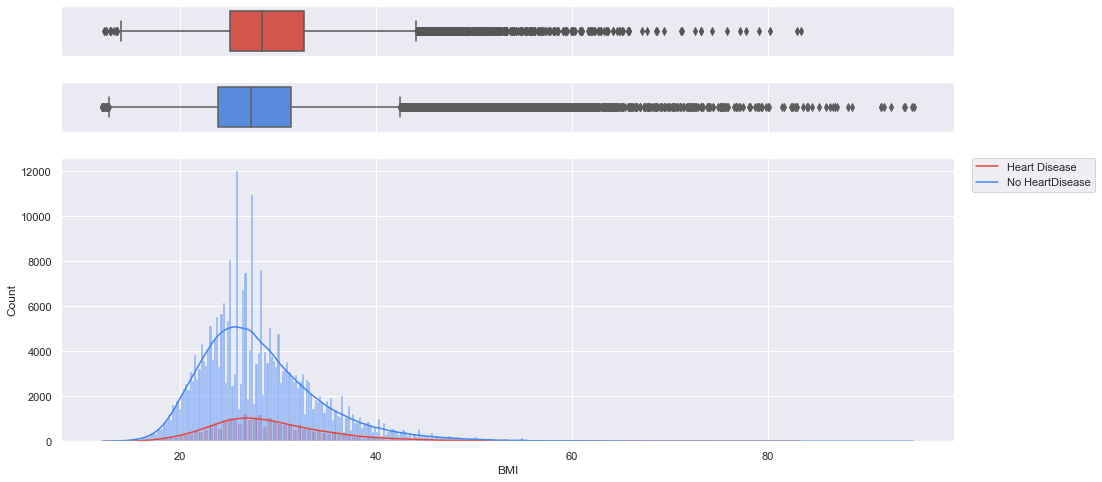

In [18]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})
 
# creating a figure composed of 3 matplotlib.Axes objects
f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .85)})
colours = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
# assigning a graph to each ax
sns.boxplot(x=df[df['HeartDisease']=='Yes']["BMI"], ax=ax_box1, color="#ea4335")
sns.histplot(df[df['HeartDisease']=='Yes'], x="BMI", ax=ax_hist, kde=True, color="#ea4335")

sns.boxplot(x=df[df['HeartDisease']=='No']["BMI"], ax=ax_box2, color='#4285f4')
sns.histplot(df[df['HeartDisease']=='No'], x="BMI", ax=ax_hist, kde=True, color='#4285f4')
 
# Remove x axis name for the boxplots
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

plt.legend(title='', loc=2, labels=['Heart Disease', 'No HeartDisease'],bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

In [19]:
df.drop('BMI',axis=1,inplace=True)

In [20]:
# Get list of columns that contain 'Yes' and 'No'
cols_with_yes_no = [col for col in df.columns if set(df[col].unique()).issubset({'Yes', 'No'})]
print(cols_with_yes_no)

['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']


In [21]:
## Replacing Yes with 1 and No with 0 for One-hot encoding
df[cols_with_yes_no] = df[cols_with_yes_no].replace({'Yes': 1, 'No': 0})

In [22]:
# Encoding the data for categorical columns
labelencoder = LabelEncoder()

order_cols = ["Bmi_Category", "AgeCategory"]
no_order_cols = ["Sex", "Race", "Diabetic","GenHealth"]

# Label encoding
for col in order_cols:
    df[col] = labelencoder.fit_transform(df[col])

# One-hot encoding
for col in no_order_cols:
    dummy_col = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummy_col], axis=1)
    del df[col]

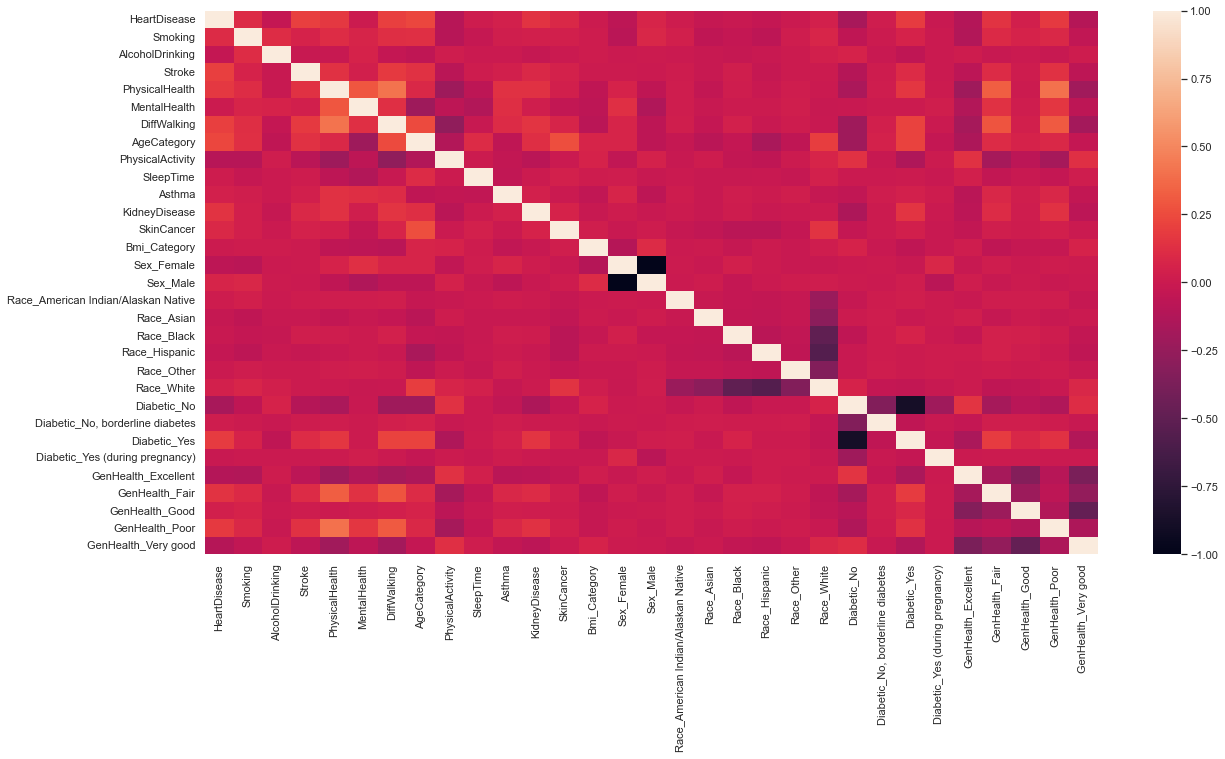

In [23]:
# Calculate the correlation matrix of the dataframe
cor = df.corr()

# Set the figure size
plt.figure(figsize=(20, 10))

# Draw the heatmap of the correlation matrix
sns.heatmap(cor)

# Get the correlation values between the target feature "heartdisease" and other features
cor_target = abs(cor["HeartDisease"])

## Model Training and Evaluation

In [24]:
## Feature Selection

In [25]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [26]:
#Chi-square Test
# Convert to categorical data by converting data to integers
X_cat = X.astype (int)

# Three features with highest chi-squared statistics are selected
chi2_features = SelectKBest (chi2, k = 3)
X_kbest_features = chi2_features.fit_transform(X_cat, y)

# Reduced features
print('Original feature number:', X_cat.shape[1])
print('Reduced feature number:', X_kbest_features.shape [1])

Original feature number: 30
Reduced feature number: 3


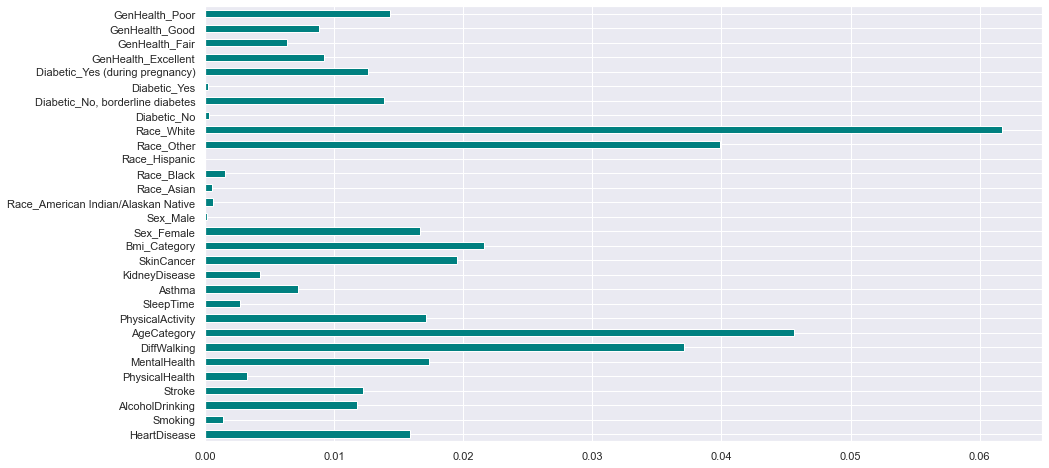

In [27]:
#Information Gain
plt.figure(figsize = (15,8))
importances = mutual_info_classif(X, y)
feat_importances = pd.Series (importances, df.columns [0:len (df.columns)-1])
feat_importances.plot(kind='barh', color= 'teal')
plt.show()

In [28]:
#Univariate Feature Selection
# Select the top 5 best features using f_classif scoring method
uni = SelectKBest(score_func = f_classif, k = 5)

# Fit the SelectKBest to X and y
fit = uni.fit(X, y)

# Get the list of columns of the selected 5 best features
X.columns[fit.get_support(indices=True)].tolist()

['Stroke', 'DiffWalking', 'AgeCategory', 'Diabetic_Yes', 'GenHealth_Poor']

In [29]:
#Wrapper Method
# Add a constant to X
X_new = sm.add_constant(X)

# Fit OLS model to X_new and y
model = sm.OLS(y, X_new).fit()

# Get the p-values of the model
p_values = model.pvalues

display(p_values)

/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                                   5.236205e-01
Smoking                                 2.886375e-97
AlcoholDrinking                         3.788570e-16
Stroke                                  0.000000e+00
PhysicalHealth                          6.466867e-13
MentalHealth                            3.481970e-01
DiffWalking                            1.766883e-113
AgeCategory                             0.000000e+00
PhysicalActivity                        7.421714e-01
SleepTime                               1.168204e-01
Asthma                                  6.995987e-29
KidneyDisease                           0.000000e+00
SkinCancer                              7.290352e-53
Bmi_Category                            2.520860e-02
Sex_Female                              5.236205e-01
Sex_Male                                5.236205e-01
Race_American Indian/Alaskan Native     5.236205e-01
Race_Asian                              5.236205e-01
Race_Black                              5.2362

In [30]:
# Initialize a list to store selected features
selected_features = list(X.columns)

# Initialize a variable to store the maximum p-value
pmax = 1

# Perform feature selection using Wrapper Method
while (len(selected_features) > 0):
    # Initialize a list to store p-values
    p = []
    
    # Select the current subset of features
    X_new = X[selected_features]
    
    # Add a constant to X_new
    X_new = sm.add_constant(X_new)
    
    # Fit a linear regression model
    model = sm.OLS(y, X_new).fit()
    # Get p-values from the model
    p = pd.Series(model.pvalues.values[1:], index=selected_features)
    
    # Get the maximum p-value
    pmax = max(p)
    
    # Get the feature with the maximum p-value
    feature_pmax = p.idxmax()
    
    # If the maximum p-value is greater than 0.05, remove the feature from the list of selected features
    if pmax > 0.05:
        selected_features.remove(feature_pmax)
    else:
        break

# Print the list of selected features
selected_features


/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'DiffWalking',
 'AgeCategory',
 'Asthma',
 'KidneyDisease',
 'SkinCancer',
 'Bmi_Category',
 'Sex_Female',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic',
 'Diabetic_No',
 'Diabetic_No, borderline diabetes',
 'Diabetic_Yes (during pregnancy)',
 'GenHealth_Fair',
 'GenHealth_Good',
 'GenHealth_Poor',
 'GenHealth_Very good']

In [31]:
X_selected = df[selected_features]
y_selected = df['HeartDisease']

In [32]:
# oversampling using SMOTE
over = SMOTE(k_neighbors=2000)
X, y = over.fit_resample(X, y)

In [33]:
over_selected = SMOTE(k_neighbors=2000)
X_selected, y_selected = over_selected.fit_resample(X_selected, y_selected)

In [34]:
X.shape

(584844, 30)

In [44]:
y.value_counts()

0    292422
1    292422
Name: HeartDisease, dtype: int64

In [35]:
def train_model(X, y, algorithm, max_iter=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    name = algorithm
    # If the max_iter parameter is specified
    if max_iter:
        model = algorithm(max_iter=max_iter)
    else:
        model = algorithm()

    # Train the model on the original dataset
    model.fit(X_train, y_train)
    
    # Predicting target variable on test data
    y_pred = model.predict(X_test)
    
    
    # Evaluation Metrics on predicted values vs test values
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print('Metrics on the data: ')
    print('Accuracy: ', acc)
    print('F1 Score: ', f1 ) 
    print('Precision: ', precision) # Positive predictive value
    print('Recall: ', recall) # Sensitivity measuement metric
    print('AUC ROC Score: ', roc_auc)

    # Confusion matrix for the data
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4))
    plt.title(f"Confusion Matrix on Dataset for {type(model).__name__}")

Metrics on the data: 
Accuracy:  0.8985286699894844
F1 Score:  0.8930711087487275
Precision:  0.943825573645625
Recall:  0.8474967512482047
AUC ROC Score:  0.8985282337073716


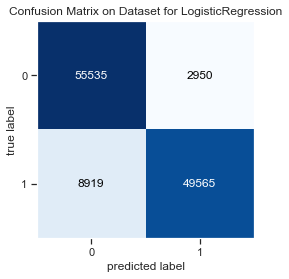

In [36]:
train_model(X,y,LogisticRegression, 1000)

Metrics on the data: 
Accuracy:  0.8173362172883414
F1 Score:  0.8192171661618127
Precision:  0.8108606076848347
Recall:  0.8277477600711306
AUC ROC Score:  0.8173363062987096


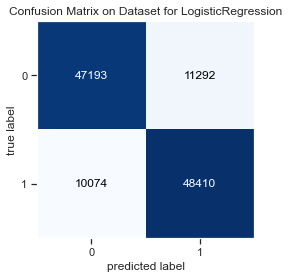

In [37]:
train_model(X_selected,y_selected,LogisticRegression, 1000)

Metrics on the data: 
Accuracy:  0.9262026690832614
F1 Score:  0.9238249880866235
Precision:  0.9545719808877704
Recall:  0.8949969222351413
AUC ROC Score:  0.92620240229907


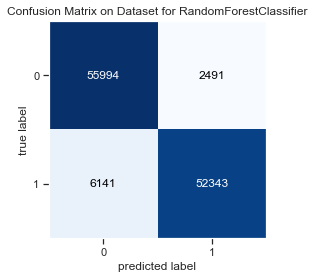

In [38]:
train_model(X, y, RandomForestClassifier)

Metrics on the data: 
Accuracy:  0.8424881806290556
F1 Score:  0.8425326062802345
Precision:  0.8422878430568372
Recall:  0.8427775117980987
AUC ROC Score:  0.8424881831026059


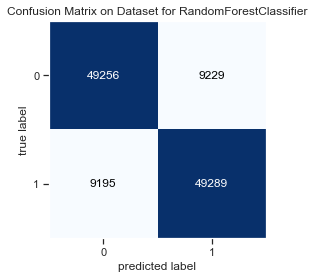

In [39]:
train_model(X_selected, y_selected, RandomForestClassifier)

Metrics on the data: 
Accuracy:  0.94142037633903
F1 Score:  0.9386977293467175
Precision:  0.9844436104334772
Recall:  0.8970145680869982
AUC ROC Score:  0.9414199967048653


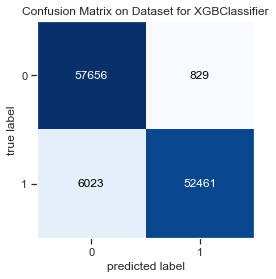

In [40]:
train_model(X,y,XGBClassifier)

Metrics on the data: 
Accuracy:  0.8972804760235618
F1 Score:  0.895958712537776
Precision:  0.9076299584203231
Recall:  0.8845838177963203
AUC ROC Score:  0.897280367477283


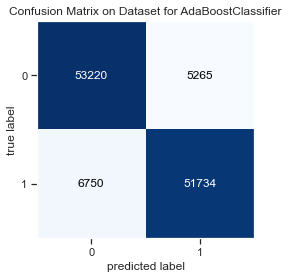

In [41]:
train_model(X,y,AdaBoostClassifier)

In [42]:
## Training model with feature selection

In [43]:
# Initialize a list to store selected features
selected_features = list(X.columns)

# Initialize a variable to store the maximum p-value
pmax = 1

# Perform feature selection using Wrapper Method
while (len(selected_features) > 0):
    # Initialize a list to store p-values
    p = []
    
    # Select the current subset of features
    X_new = X[selected_features]
    
    # Add a constant to X_new
    X_new = sm.add_constant(X_new)
    
    # Fit a linear regression model
    model = sm.OLS(y, X_new).fit()
    
    # Get p-values from the model
    p = pd.Series(model.pvalues.values[1:], index=selected_features)
    
    # Get the maximum p-value
    pmax = max(p)
    
    # Get the feature with the maximum p-value
    feature_pmax = p.idxmax()
    
    # If the maximum p-value is greater than 0.05, remove the feature from the list of selected features
    if pmax > 0.05:
        selected_features.remove(feature_pmax)
    else:
        break

# Print the list of selected features
selected_features

/Users/pranjaliagarwal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'AgeCategory',
 'PhysicalActivity',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer',
 'Bmi_Category',
 'Sex_Female',
 'Sex_Male',
 'Race_American Indian/Alaskan Native',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic',
 'Race_Other',
 'Race_White',
 'Diabetic_No',
 'Diabetic_No, borderline diabetes',
 'Diabetic_Yes',
 'Diabetic_Yes (during pregnancy)',
 'GenHealth_Excellent',
 'GenHealth_Fair',
 'GenHealth_Good',
 'GenHealth_Poor',
 'GenHealth_Very good']